In [1]:
#load and preprocess data
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5
with tf.device('/gpu:0'):
    BUFFER_SIZE = 60000
    BATCH_SIZE = 256
    # Batch and shuffle the data
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5
with tf.device('/gpu:0'):
    BUFFER_SIZE = 10000
    BATCH_SIZE = 256
    # Batch and shuffle the data
    test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-01-31 20:30:25.871953: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-31 20:30:27.083663: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-31 20:30:27.084622: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-31 20:30:27.111233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-31 20:30:27.111509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-31 20:3

In [2]:
#build generator
inp_gen = tf.keras.layers.Input(shape=(100,))
x = tf.keras.layers.Dense(7*7*128, use_bias = False)(inp_gen)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Reshape((7,7,128))(x)

x = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=2, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2DTranspose(64, (5,5), strides=2, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2DTranspose(32, (5,5), strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)


out_gen = tf.keras.layers.Conv2DTranspose(1, (5,5), strides=1, padding='same', use_bias=False, activation='tanh')(x)
generator = tf.keras.models.Model(inp_gen, out_gen)


In [3]:
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              627200    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
re_lu (ReLU)                 (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512   

In [4]:
# create 150 noise vector of dim 100 randomly, and generate images via an untrained generator
with tf.device('/gpu:0'):
   noise = tf.random.normal([150, 100])    #batch_size = 1, latent_dim = 100
   generated_image = generator(noise)      #shape of generated image: [150, 28, 28, 1]

2023-01-31 20:30:39.110851: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-01-31 20:30:39.305988: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


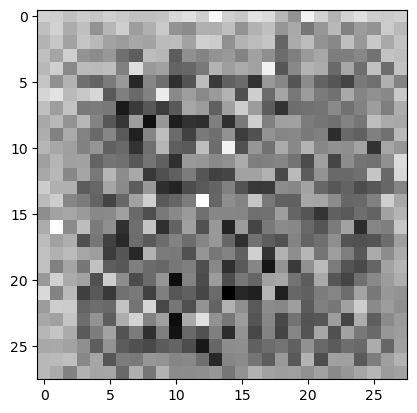

In [5]:
#display one of the generated images
import matplotlib.pyplot as plt
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [6]:
#build discriminator
inp_disc = tf.keras.layers.Input(shape=(28,28,1))

x = tf.keras.layers.LeakyReLU(alpha=0.2)(inp_disc)
x = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')(x)

x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)


x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)

x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same')(x)

x = tf.keras.layers.Flatten()(x)
out_disc = tf.keras.layers.Dense(units=1)(x)

discriminator = tf.keras.models.Model(inp_disc, out_disc)

In [7]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         2049

In [8]:
with tf.device('/gpu:0'):
    print(discriminator(generated_image[5:6]))

tf.Tensor([[2.1907945e-05]], shape=(1, 1), dtype=float32)


In [9]:
#loss function, optimizer, batch_size
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
lr = 2e-4
decay = 6e-8
generator_optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
noise_dim = 100
BATCH_SIZE = 256
train_iteration=25000

In [11]:
with tf.device('/gpu:0'):   
    real_label = tf.ones(shape=(BATCH_SIZE,1))
    fake_label = tf.zeros(shape=(BATCH_SIZE,1))

    loss_metric_disc = tf.keras.metrics.BinaryCrossentropy(from_logits=True)
    loss_metric_gen = tf.keras.metrics.BinaryCrossentropy(from_logits=True)
    
    acc_metric_disc = tf.keras.metrics.BinaryAccuracy()
    acc_metric_gen = tf.keras.metrics.BinaryAccuracy()
    

    plot_loss_disc = []
    plot_acc_disc = []
    plot_loss_gen = []
    plot_acc_gen = []

    for itr in range(train_iteration):
        image_batch = next(iter(train_dataset))
        noise_dim = 100
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        with tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=False)
            real_output = discriminator(image_batch, training=True)
            fake_output = discriminator(generated_images, training=True)

            real_loss = cross_entropy(tf.ones_like(real_output), real_output)
            fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
            disc_loss = real_loss + fake_loss
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_weights))

        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        with tf.GradientTape() as gen_tape:
            generated_images = generator(noise, training=True)
            fake_output = discriminator(generated_images, training=False)

            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
        
        image_batch_val = next(iter(test_dataset))
        image_batch_val = tf.cast(image_batch_val, dtype=tf.dtypes.float32)
        noise_val = tf.random.normal([BATCH_SIZE, noise_dim])
        generated_images_val = generator(noise_val, training=True)
        generated_images_val = tf.cast(generated_images_val, dtype=tf.dtypes.float32)
        label = tf.concat((real_label, fake_label), axis=0)
        data = tf.concat((image_batch_val, generated_images_val), axis=0)
        logits_disc = discriminator(data, training=False)
        logits_gen = discriminator(generated_images_val, training=False)

        # Update training metric.
        loss_metric_disc.update_state(label, logits_disc)
        loss_metric_gen.update_state(real_label, logits_gen)
        acc_metric_disc.update_state(label, logits_disc)
        acc_metric_gen.update_state(real_label, logits_gen)
        
        if (itr + 1) % 100 == 0:
            loss_disc = loss_metric_disc.result()
            loss_gen = loss_metric_gen.result()
            
            acc_disc = acc_metric_disc.result()
            acc_gen = acc_metric_gen.result()
            

            plot_loss_disc.append(loss_disc)
            plot_loss_gen.append(loss_gen)

            plot_acc_disc.append(acc_disc)
            plot_acc_gen.append(acc_gen)
            
            print('train BinaryCrossentropyloss discriminator/generator acc at iteration %d: %.4f/%.4f ' % (itr+1, float(loss_disc), float(loss_gen)))
            print("Training accuracy discriminator/generator at iteration %d: %.4f/ %.4f" % (itr+1, float(acc_disc), float(acc_gen)))
            acc_metric_disc.reset_states()
            acc_metric_gen.reset_states()

            loss_metric_disc.reset_states()
            loss_metric_gen.reset_states()
    

train BinaryCrossentropyloss discriminator/generator acc at iteration 100: 1.6449/0.1673 
Training accuracy discriminator/generator at iteration 100: 0.4282/ 0.8872
train BinaryCrossentropyloss discriminator/generator acc at iteration 200: 0.9424/0.4578 
Training accuracy discriminator/generator at iteration 200: 0.4144/ 0.4882
train BinaryCrossentropyloss discriminator/generator acc at iteration 300: 0.6954/0.6915 
Training accuracy discriminator/generator at iteration 300: 0.5028/ 0.0058
train BinaryCrossentropyloss discriminator/generator acc at iteration 400: 0.6843/0.7138 
Training accuracy discriminator/generator at iteration 400: 0.5013/ 0.0002
train BinaryCrossentropyloss discriminator/generator acc at iteration 500: 0.6775/0.7233 
Training accuracy discriminator/generator at iteration 500: 0.5065/ 0.0011
train BinaryCrossentropyloss discriminator/generator acc at iteration 600: 0.6812/0.7139 
Training accuracy discriminator/generator at iteration 600: 0.5061/ 0.0036
train Bina

In [18]:
with tf.device('/gpu:0'):
   train_iteration=25000

   real_label = tf.ones(shape=(BATCH_SIZE,1))
   fake_label = tf.zeros(shape=(BATCH_SIZE,1))

   acc_metric_disc = tf.keras.metrics.BinaryCrossentropy(from_logits=True)
   acc_metric_gen = tf.keras.metrics.BinaryCrossentropy(from_logits=True)
   loss_avg_disc = tf.keras.metrics.Mean()
   loss_avg_gen = tf.keras.metrics.Mean()

   plot_loss_disc = []
   plot_acc_disc = []
   plot_loss_gen = []
   plot_acc_gen = []

   for itr in range(train_iteration):
       image_batch = next(iter(train_dataset))
       noise_dim = 100
       noise = tf.random.normal([BATCH_SIZE, noise_dim])
       with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
           generated_images = generator(noise, training=True)
           real_output = discriminator(image_batch, training=True)
           fake_output = discriminator(generated_images, training=True)

           gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
           real_loss = cross_entropy(tf.ones_like(real_output), real_output)
           fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
           disc_loss = real_loss + fake_loss
       gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
       gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)

       discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_weights))
       generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    
       image_batch = tf.cast(image_batch, dtype=tf.dtypes.float32)
       generated_images = tf.cast(generated_images, dtype=tf.dtypes.float32)
       label = tf.concat((real_label, fake_label), axis=0)
       data = tf.concat((image_batch, generated_images), axis=0)
       logits_disc = discriminator(data, training=False)
       logits_gen = discriminator(generated_images, training=False)
    
       # Update training metric.
       acc_metric_disc.update_state(label, logits_disc)
       acc_metric_gen.update_state(real_label, logits_gen)
       loss_avg_disc.update_state(disc_loss)
       loss_avg_gen.update_state(gen_loss)
       if (itr + 1) % 100 == 0:
           acc_disc = acc_metric_disc.result()
           acc_gen = acc_metric_gen.result()

           loss_disc = loss_avg_disc.result()
           loss_gen = loss_avg_gen.result()

           plot_loss_disc.append(loss_disc)
           plot_loss_gen.append(loss_gen)

           plot_acc_disc.append(acc_disc)
           plot_acc_gen.append(acc_gen)
           
           print('train acc discriminator/generator acc at iteration %d: %.4f/%.4f ' % (itr+1, float(acc_disc), float(acc_gen)))
           #print("Training loss discriminator/generator at iteration %d: %.4f/ %.4f" % (itr+1, float(train_loss_disc), float(train_loss_gen)))
           acc_metric_disc.reset_states()
           acc_metric_gen.reset_states()

           loss_avg_disc.reset_states()
           loss_avg_gen.reset_states()

train acc discriminator/generator acc at iteration 100: 0.5265/0.9753 
train acc discriminator/generator acc at iteration 200: 0.6465/0.7718 


KeyboardInterrupt: 

In [19]:
generator.save('mnistgenerator')

2023-01-16 14:43:36.814596: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: mnistgenerator/assets


In [1]:
import tensorflow as tf
generator = tf.keras.models.load_model('mnistgenerator')

2023-05-09 19:16:14.296129: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


OSError: SavedModel file does not exist at: mnistgenerator/{saved_model.pbtxt|saved_model.pb}

In [8]:

with tf.device('/gpu:0'):
   tf.random.set_seed(5)
   noise = tf.random.normal([600, 100])    #batch_size = 1, latent_dim = 100
   generated_image = generator(noise)

In [13]:
tf.random.set_seed(4)
noise = tf.random.normal([600, 100]) 
generated_image2 = generator(noise)

In [16]:
g = tf.concat([generated_image, generated_image2], axis=0)

In [17]:
g.shape

TensorShape([1200, 28, 28, 1])

In [12]:
type(generated_image), generated_image.shape

(tensorflow.python.framework.ops.EagerTensor, TensorShape([600, 28, 28, 1]))

In [18]:
batch = 200
generated_images = None
for i in range(300):
    tf.random.set_seed(i)
    noise = tf.random.normal([batch, 100])
    generated_image = generator(noise)
    if generated_images is None:
        generated_images = generated_image
    else:
        generated_images = tf.concat([generated_images, generated_image], axis=0)


In [19]:
generated_images.shape

TensorShape([60000, 28, 28, 1])

In [28]:
tf.reduce_min(generated_images)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.0>

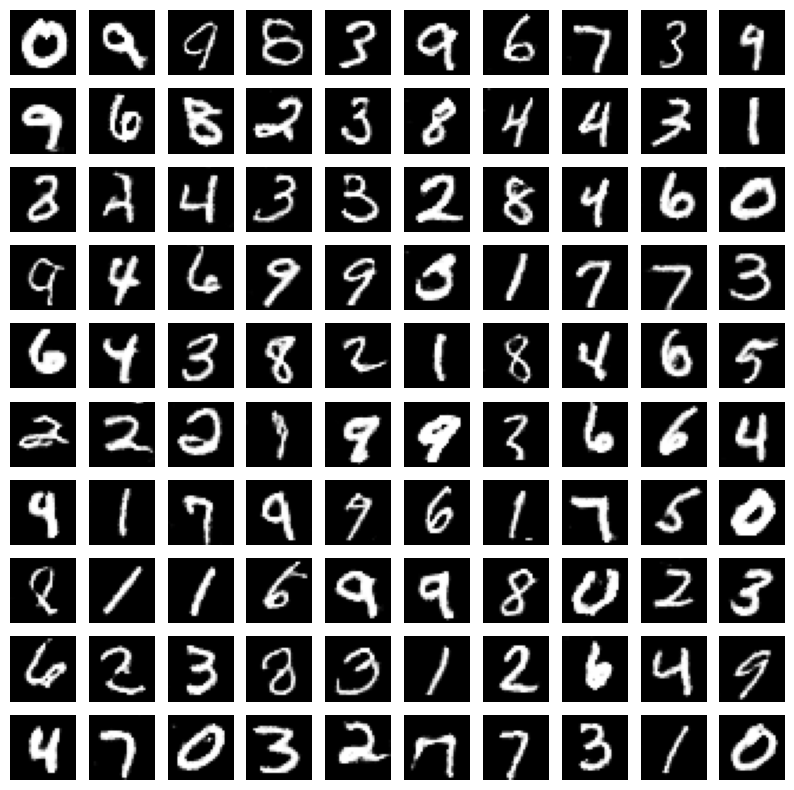

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(generated_image[i+200, :, :, 0], cmap='gray')
  plt.axis('off')

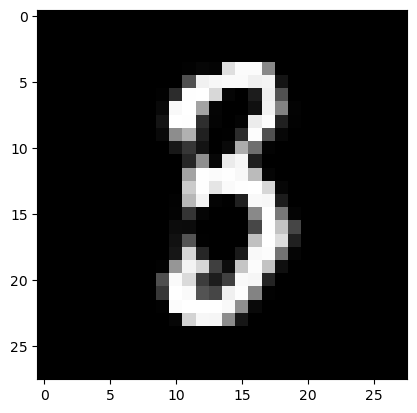

In [34]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [20]:
#construct classification model
import tensorflow as tf
inp = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid')(inp)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='valid')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='valid')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='valid')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='valid')(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.BatchNormalization()(x)
 
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units=512, activation='relu')(x)

x = tf.keras.layers.Dense(units=10, activation='softmax')(x)

In [21]:
model = tf.keras.models.Model(inp, x)

In [22]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [31]:
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images-127.5)/127.5

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128,  epochs=20, validation_split=0.2)

In [34]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images-127.5)/127.5
loss_accuracy = model.evaluate(test_images, test_labels, verbose=0)

In [35]:
loss_accuracy[1]

0.9919000267982483

In [38]:
train_images.shape, generated_images.shape

((60000, 28, 28, 1), TensorShape([60000, 28, 28, 1]))

In [41]:
generated_images[0:200].shape

TensorShape([200, 28, 28, 1])

In [44]:
tf.reduce_sum(model(generated_images[0:10])[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [48]:
i = 0
prob = model(generated_images[200*i:200*(i+1)])
prob.shape, type(prob)

(TensorShape([200, 10]), tensorflow.python.framework.ops.EagerTensor)

In [50]:
probs = None
for i in range(300):
    prob = model(generated_images[200*i:200*(i+1)])
    if probs is None:
        probs = prob
    else:
        probs = tf.concat([probs, prob], axis=0)
probs.shape
    


TensorShape([60000, 10])

In [67]:
p_yx = probs
p_y = tf.expand_dims(tf.reduce_mean(p_yx, axis=0), 0)
eps=1E-16
# kl divergence for each image
kl_d = p_yx * (tf.math.log(p_yx + eps) - tf.math.log(p_y + eps))
sum_kl_d = tf.reduce_sum(kl_d, axis=1)
avg_kl_d = tf.reduce_mean(sum_kl_d)
is_score = tf.math.exp(avg_kl_d)
is_score

<tf.Tensor: shape=(), dtype=float32, numpy=9.471862>

In [ ]:
import tensorflow as tf
inp_gen = tf.keras.layers.Input(shape=(100,))
x = tf.keras.layers.Dense(7*7*128, use_bias = False)(inp_gen)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Reshape((7,7,128))(x)

x = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=2, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2DTranspose(64, (5,5), strides=2, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.Conv2DTranspose(32, (5,5), strides=1, padding='same', use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)


out_gen = tf.keras.layers.Conv2DTranspose(1, (5,5), strides=1, padding='same', use_bias=False, activation='tanh')(x)


In [3]:
generator = tf.keras.models.Model(inp_gen, out_gen)

In [4]:
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              627200    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
re_lu (ReLU)                 (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512   

In [2]:
class DCGAN(object):
   def __init__(self, datasource, latent_dim, *initializer):
      self.datasource = datasource
      self.latentdim = latent_dim
      #self.input_dims = [64, 64, 3] if self.datasource == 'tiny-imagenet' else [32, 32, 3]
      self.convinitializer = initializer[0]
      self.denseinitializer = initializer[1]
   def construct_weights(self, trainable=True):
       weight = {}
       if self.datasource == 'mnist':
          DeconvInput = 7 * 7 * 128
       weight['w1_fc'] = tf.Variable(self.denseinitializer(shape=(self.latentdim, DeconvInput)),name='w1', trainable=trainable)
       weight['w2_Dconv'] = tf.Variable(self.convinitializer(shape=(5,5,128,128)), name='w2', trainable=trainable)
       weight['w3_Dconv'] = tf.Variable(self.convinitializer(shape=(5,5,64,128)), name='w3', trainable=trainable)
       weight['w4_Dconv'] = tf.Variable(self.convinitializer(shape=(5,5,32,64)), name='w4', trainable=trainable)
       weight['w5_Dconv'] = tf.Variable(self.convinitializer(shape=(5,5,1,32)), name='w5', trainable=trainable)
       return weight
       
  



In [3]:
import tensorflow as tf
class ConvTwoTranspose(tf.keras.layers.Layer):
    def __init__(self, weight, outputshape, stridesList, padding):
        super(ConvTwoTranspose,self).__init__()
        self.w = tf.Variable(initial_value=weight, trainable=True)
        self.outputshape = outputshape
        self.strides = stridesList
        self.padding = padding

    def call(self, inputs):
        return tf.nn.conv2d_transpose(inputs, self.w, self.outputshape, self.strides, self.padding) 

class DenseGan(tf.keras.layers.Layer):
    def __init__(self, weight, activation):
        super(DenseGan, self).__init__()
        self.w = tf.Variable(initial_value=weight, trainable=True)
        self.activation = activation
    def call(self,input):
        return self.activation(tf.matmul(input, self.w))



2023-01-19 00:47:13.532238: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
initializer1 = tf.initializers.variance_scaling()
initializer2 = tf.initializers.variance_scaling()
net = DCGAN('mnist', 100, initializer1, initializer2)
weight = net.construct_weights()

2023-01-19 00:47:16.682654: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-19 00:47:16.684217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-19 00:47:16.715838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-19 00:47:16.716138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-01-19 00:47:16.716150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-01-19 00:4

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [9]:
batch_size = 250
inp = tf.keras.layers.Input(shape= (100,))
fc1 = DenseGan(weight['w1_fc'], tf.keras.activations.linear)(inp)
batchnorm1 = tf.keras.layers.BatchNormalization()(fc1)
Rel1 = tf.keras.layers.ReLU()(batchnorm1)
DeconvInput = tf.keras.layers.Reshape((7,7,128))(Rel1)

Deconv2 = ConvTwoTranspose(weight['w2_Dconv'], [batch_size,14,14,128],[1,2,2,1],'SAME')(DeconvInput)
batchnorm2 = tf.keras.layers.BatchNormalization()(Deconv2)
Rel2 = tf.keras.layers.ReLU()(batchnorm2)

Deconv3 = ConvTwoTranspose(weight['w3_Dconv'], [batch_size,28,28,64],[1,2,2,1],'SAME')(Rel2)
batchnorm3 = tf.keras.layers.BatchNormalization()(Deconv3)
Rel3 = tf.keras.layers.ReLU()(batchnorm3)

Deconv4 = ConvTwoTranspose(weight['w4_Dconv'], [batch_size,28,28,32],[1,1,1,1],'SAME')(Rel3)
batchnorm4 = tf.keras.layers.BatchNormalization()(Deconv4)
Rel4 = tf.keras.layers.ReLU()(batchnorm4)

Deconv5 = ConvTwoTranspose(weight['w5_Dconv'], [batch_size,28,28,1],[1,1,1,1],'SAME')(Rel4)
out = tf.keras.activations.tanh(Deconv5)

model = tf.keras.models.Model(inp, out)


In [10]:

tf.random.set_seed(5)
noise = tf.random.normal([250, 100])

In [1]:
model2 = tf.keras.models.Model(inp, DeconvInput)
model2(noise)

NameError: name 'tf' is not defined

In [ ]:
with tf.device('/gpu:1'):
    model(noise)

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 6272)              627200    
_________________________________________________________________
batch_normalization_30 (Batc (None, 6272)              25088     
_________________________________________________________________
re_lu_30 (ReLU)              (None, 6272)              0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv_two_transpose_23 (ConvT (None, 14, 14, 128)       409600    
_________________________________________________________________
batch_normalization_31 (Batc (None, 14, 14, 128)       512   